# Przykłady pracy z TF-IDF

## Podstawowa intuicja

In [1]:
a = "purple is the best city in the forest".split()
b = "there is an art to getting your way and throwing bananas on to the street is not it".split()
c = "it is not often you find soggy bananas on the street".split()

In [2]:
import numpy as np

docs = [a, b, c]

def tf_idf(word, sentence):
    tf = sentence.count(word) / len(sentence)
    print(f'TF={tf}')
    idf = np.log10(len(docs) / sum([1 for doc in docs if word in doc]))
    print(f'IDF={idf}')
    print(f'TFIDF={round(tf*idf, 4)}')

In [3]:
tf_idf('forest', a)


TF=0.125
IDF=0.47712125471966244
TFIDF=0.0596


In [4]:
tf_idf('forest', b)

TF=0.0
IDF=0.47712125471966244
TFIDF=0.0


# 1.  Przykłady na artykułach z Wikipedii

In [5]:
!pip install -q wikipedia
!pip install -q wordcloud
import wikipedia

  Preparing metadata (setup.py) ... done


In [6]:
wikipedia.set_lang("en")
person = wikipedia.page("Lionel Messi", auto_suggest=False)
print(person.content[:200])

Lionel Andrés "Leo" Messi (Spanish pronunciation: [ljoˈnel anˈdɾes ˈmesi] ; born 24 June 1987) is an Argentine professional footballer who plays as a forward for and captains both Major League Soccer 


In [7]:
people = ["Iga Świątek", "Robert Lewandowski", "Christiano Ronaldo", "Steven Spielberg", 'Lionel Messi']
dat = [{'Person': person, 'Content': wikipedia.page(person, auto_suggest=False).content} for person in people]

# uwaga, często dana strona nie jest znajdowana należy użyć wikipedia.search gdy wystąpi probem
#wikipedia.search("iga swiatek")

In [8]:
import wordcloud

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

pd.set_option("display.precision", 4)

df_sentences = pd.DataFrame(dat)
df_sentences


,Person,Content
0,Iga Świątek,Iga Natalia Świątek (Polish pronunciation: [ˈi...
1,Robert Lewandowski,Robert Lewandowski (Polish pronunciation: [ˈrɔ...
2,Christiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro (Portugue...
3,Steven Spielberg,Steven Allan Spielberg KBE (; born December 18...
4,Lionel Messi,"Lionel Andrés ""Leo"" Messi (Spanish pronunciati..."


## 2. Vectorize text to a numeric matrix      

In [9]:
sentences = df_sentences['Content'].values.tolist()
vocab=None
min_df=0.0
max_df=1.0
ngram_range=(1,1)


# Build count vectorizer
count_vectorizer = CountVectorizer(max_df=max_df, min_df=min_df, vocabulary=vocab, ngram_range=(1,1))
cvec = count_vectorizer.fit(sentences)

# Get feature names
feature_names = cvec.get_feature_names_out()

# Get bag-of-words and analyze
bag_of_words = cvec.transform(sentences)
df_bag_of_words = pd.DataFrame(bag_of_words.todense(), columns=feature_names)

# Transform bag_of_words into tf-idf matrix
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(bag_of_words)

# Find most popular words and highest weights
word_cnts = np.asarray(bag_of_words.sum(axis=0)).ravel().tolist()  # for each word in column, sum all row counts
df_cnts = pd.DataFrame({'word': feature_names, 'count': word_cnts})
df_cnts = df_cnts.sort_values('count', ascending=False)

# Build word weights as a list and sort them
weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
df_weights = pd.DataFrame({'word': feature_names, 'weight': weights})
df_weights = df_weights.sort_values('weight', ascending=False)

df_weights = df_weights.merge(df_cnts, on='word', how='left')
df_weights = df_weights[['word', 'count', 'weight']]

# Cosine similarity of sentences
cos_sim = cosine_similarity(tfidf, tfidf)

# Distance matrix of sentences
samp_dist = 1 - cos_sim


# Build

df_tfidf = pd.DataFrame(tfidf.todense(), columns=feature_names)
print("%d dummy sentences:" % len(sentences))
print(sentences)
print("---")


print("%d feature_names (each feature represents a distinct word):" % len(feature_names))
print(feature_names)
print("---")
print("df_tfidf[%d,%d]:" % (len(sentences), len(feature_names)))
print(df_tfidf.to_string())
print("---")
print("df_weights:")
print(df_weights)
print("---")
print("cos_sim[%d,%d] (a square matrix of length and width = len(sentences)):" % (len(sentences), len(sentences)))
print(cos_sim)

5 dummy sentences:
['Iga Natalia Świątek (Polish pronunciation: [ˈiɡa naˈtalja ˈɕfjɔntɛk] ; born 31 May 2001) is a Polish professional tennis player. She is currently ranked  as the world No. 1 in women\'s singles by the Women\'s Tennis Association (WTA), having held the position for a total of 95 weeks. Świątek is a four-time major singles champion, having won the French Open in 2020, 2022, and 2023 and the US Open in 2022. She is the first player representing Poland to win a major singles title. She has won a total of 19 singles titles, including the 2023 WTA Finals.\nŚwiątek\'s father, Tomasz, is a retired Olympic rower. As a junior, Świątek was the 2018 French Open girls\' doubles champion alongside Caty McNally and the 2018 Wimbledon girls\' singles champion. Świątek began playing regularly on the WTA Tour in 2019, and entered the top 50 at 18 years old after her first Tour final and a fourth-round appearance at the 2019 French Open.\nDuring her French Open title run in 2020, Świą

**Note how the above cosine similarity matrix corresponds to the original bag-of-words representation shown below:  **

* Row 0 cosine similarity values are not similar to rows 1 to 4  
* Rows 1 and 2 contain similar values (they are not identical due to the extra word in row 2: 'ddd')
* Rows 3 and 4 contain identical values (with columns 3 and 4 shifted)

## Build a word cloud from the weighted word counts

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
ethic 3
espn 3
clear 3
200th 3
van 3
armenia 3
triumph 3
silva 3
revolves 4
possibility 4
diagnosed 4
supporting 4
gary 4
freedom 4
gained 4
ceremony 4
suggested 4
belgium 4
instead 4
garnered 4
creator 4
enjoyed 4
fiorentina 3
trafford 3
ricardo 3
renamed 3
daei 3
luxembourg 3
allegation 3
allegri 3
sassuolo 3
fpf 3
capocannoniere 3
platini 3
campus 3
district 3
praise 3
karim 3
sampdoria 3
algarve 3
décima 3
reports 3
captained 3
málaga 3
michel 3
haul 3
crosses 3
bolton 3
tottenham 3
ghana 3
lawsuit 3
mandžukić 3
coppa 3
approach 3
features 3
aesthetically 3
adopted 3
applied 3
enough 3
police 3
marriage 3
chance 3
risks 3
sisters 3
survivor 3
investors 3
credited 3
law 3
custody 3
doesn 3
natural 3
influenced 3
takes 3
reaction 3
tv 3
heads 3
limited 3
jennifer 3
technology 3
rated 3
todd 3
thereby 4
capital 4
range 4
30th 4
handed 4
seconds 4
defensive 4
japan 4
pace 4
boots 4
selling 4
stéfano 4
di 4
ground 4
sponso

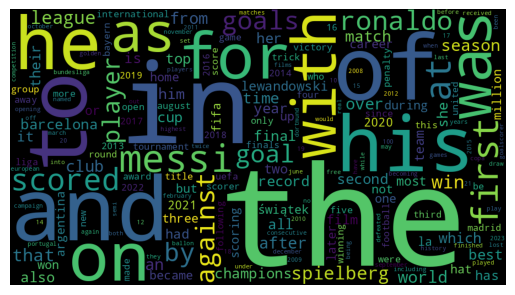

In [10]:
print(df_weights)
s_word_freq = pd.Series(df_weights['count'])
s_word_freq.index = df_weights['word']
di_word_freq = s_word_freq.to_dict()

print("---")
print("di_word_freq:")
for k,v in di_word_freq.items():
  print(k,v)

cloud = wordcloud.WordCloud(width=900, height=500).generate_from_frequencies(di_word_freq)
plt.imshow(cloud)
plt.axis('off')
plt.show()

## 3. Dimensionality Reduction using PCA

Before attempting to cluster the data, we will usually want to reduce the dimensionality of the data because this helps to mitigate the problem of overfitting. Note the distinction between the two terms:

* Dimensionality reduction: find the linear combinations of variables that are most 'interesting' in the data. For example, the polular PCA technique finds linear transformations of input features that maximize the variance of the data points along the new axes.

* Clustering: find data points that can be grouped together as separate classes.

In [11]:
# Dimensionality reduction using PCA, reduce the tfidf matrix to just 2 features
X = tfidf.todense()
print("X before reduction:")
print(X)
print('\n\n')

X = np.array(X)
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

print("X_pca now has just 2 columns:")
print(X_pca)

X before reduction:
[[0.00677869 0.         0.         ... 0.         0.00284517 0.        ]
 [0.00590583 0.00138341 0.         ... 0.00206567 0.         0.        ]
 [0.00440263 0.0023204  0.00093179 ... 0.         0.         0.        ]
 [0.0029829  0.         0.         ... 0.         0.         0.        ]
 [0.00452758 0.00127267 0.00153317 ... 0.         0.         0.00095016]]



X_pca now has just 2 columns:
[[ 0.2425658   0.48242784]
 [-0.25453675 -0.03012904]
 [-0.21951647 -0.05665323]
 [ 0.44728355 -0.33556231]
 [-0.21579613 -0.06008327]]


##4. Calculate K-means clusters (unsupervised classification)

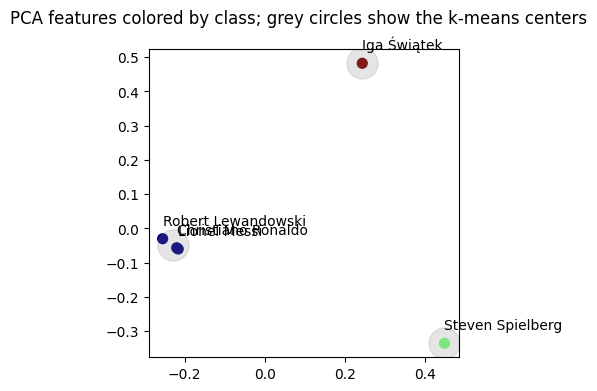

In [14]:
N_CLUSTERS = 3
km_model = KMeans(n_clusters=N_CLUSTERS, max_iter=10, n_init=2, random_state=121)

# K-means (from number of features in input matrix to n_clusters)
km_model.fit(X_pca)
df_centers = pd.DataFrame(km_model.cluster_centers_, columns=['x', 'y'])

plt.figure(figsize=(4,4))
plt.suptitle('PCA features colored by class; grey circles show the k-means centers')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km_model.labels_, s=50, cmap='jet')
plt.scatter(df_centers['x'], df_centers['y'], c='grey', s=500, alpha=0.2);

dy = 0.04
for i, txt in enumerate(km_model.labels_):
    my_label = df_sentences.iloc[i]['Person']
    plt.annotate(my_label, (X_pca[i, 0], X_pca[i, 1] + dy))


**Note above how the center coordinates for the k-means model correspond to the original sentences shown below. The dimensions of the centers are: (n_clusters, n_features). Each row corresponds to one of the sentences. We often run PCA as the first step and therefore end up with 2 remaining features (n_features = 2). **

## Summary

The following data science techniques were demonstrated in the context of NLP (Natural Language Processing) using python's nltk library:

* Vectorize text to a numeric matrix using TF-IDF

* Dimensionality Reduction using PCA

* Calculate K-means clusters (unsupervised classification)